# Introduction
Create figures for diffusive $U \to S$ binding

### Imports
Import libraries and write settings here.

In [88]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as colors

### Style settings

In [109]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 30,
    "lines.linewidth": 3,
    "lines.markersize": 10,
    "xtick.labelsize": 30,
    "ytick.labelsize": 30,
    "font.size": 28,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)
        

### Locations

In [59]:
# workstation
#%cd /home/alamson/DATA/AMSOS_methods

# mnt
#%cd /mnt/home/alamson/projects/DATA/AMSOS_methods/

# ceph
%cd /mnt/home/alamson/ceph/DATA/AMSOS_Methods/

/mnt/ceph/users/alamson/DATA/AMSOS_Methods


In [60]:
ws_path = Path('/home/alamson/DATA/AMSOS_Methods/')
mnt_path = Path.home() / 'projects/DATA/AMSOS_Methods/'
ceph_path = Path.home() / 'ceph/DATA/AMSOS_Methods/'

# Functions

In [61]:
def get_bind_arr(h5_path):
    with h5py.File(h5_path, 'r') as h5_file:
        xlp_bind = np.sum(h5_file['raw_data/proteins'][:,-2:, :] != -1, axis=0)
        time = h5_file['time'][...]
    return time, xlp_bind

In [62]:
def get_sd_bind_arr(h5_path):
    with h5py.File(h5_path, 'r') as h5_file:
        xlp_bind_ind = h5_file['raw_data/proteins'][:,-2:, :]
        # Count all heads that are not bound minus 1 for the single unbound protein
        xlp_s_bind = (xlp_bind_ind < 0).sum(axis=0)-1 
        # Count all doubly bound proteins i.e. no head unbound
        xlp_d_bind = ((xlp_bind_ind[:,0,:] > -1) * (xlp_bind_ind[:,1,:] > -1)).sum(axis=0)
        time = h5_file['time'][...]
    return time, xlp_s_bind, xlp_d_bind


In [63]:
def get_param_val(h5_path, param):
    with h5py.File(h5_path, 'r') as h5_file:
        params = yaml.safe_load(h5_file.attrs['ProteinConfig'])
    return params['proteins'][0][param]

def get_xl_params(h5_path):
    with h5py.File(h5_path, 'r') as h5_file:
        params = yaml.safe_load(h5_file.attrs['ProteinConfig'])
    return params['proteins'][0]

def get_run_params(h5_path):
    with h5py.File(h5_path, 'r') as h5_file:
        params = yaml.safe_load(h5_file.attrs['RunConfig'])
    return params

# Baseline results

In [64]:
# workstation
%cd /home/alamson/DATA/AMSOS_Methods

/home/alamson/DATA/AMSOS_Methods


## Diffusion scan

In [65]:
data_path = ws_path / "21-05-10_AMrod_US_binding_test/"
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    #for atr in h5_data['raw_data/proteins'].attrs:
    #    print(atr)
    h5_data['raw_data/sylinders'].attrs['column labels']

array(['gid', 'radius', 'minus pos x', 'minus pos y', 'minus pos z',
       'plus pos x', 'plus pos y', 'plus pos z', 'group'], dtype=object)

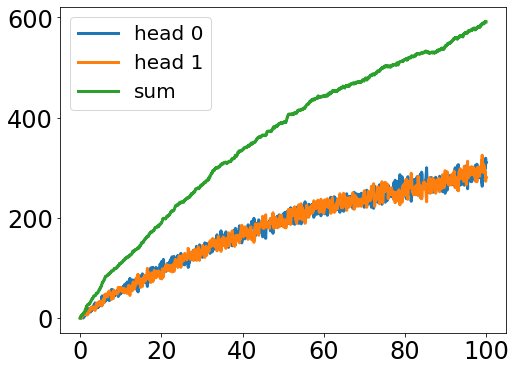

In [66]:
data_path = ws_path / "21-05-10_AMrod_US_binding_test/"
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    xlp_bind = np.sum(h5_data['raw_data/proteins'][:,-2:, :] != -1, axis=0)
    time = h5_data['time'][...]
    fig, ax = plt.subplots(figsize=(8,6))
    
    _ = ax.plot(time, xlp_bind[0,:], label='head 0')
    _ = ax.plot(time, xlp_bind[1,:], label='head 1')
    _ = ax.plot(time, np.sum(xlp_bind, axis = 0), label='sum')
    _ = ax.legend()

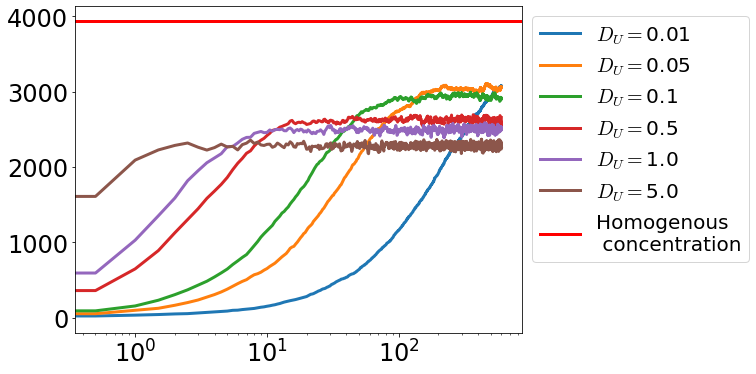

In [67]:
h5_dirs = Path('21-05-11_AMrod_US_binding_scan6.1_uDiff.01-5/simulations/').glob('*/*.h5')

fig, ax = plt.subplots(figsize=(8,6))
label_vals = []
length = 1.
for h5_path in h5_dirs:
    time, xlp_bind = get_bind_arr(h5_path)
    label_vals += [get_param_val(h5_path, 'diffUnbound')]
    params = get_xl_params(h5_path)
    run_params = get_run_params(h5_path)
    _ = ax.plot(time, np.sum(xlp_bind, axis = 0), label=f'$D_U =${label_vals[-1]}')
    Ka = params['Ka'][0]
    eps = params['eps']
    Nxl = params['freeNumber']
    vol = (run_params['simBoxHigh'][0] - run_params['simBoxLow'][0])**3
    gamma = 2.*Ka*eps*length/vol/602
    calc_val = Nxl/(1.+(1./gamma))

    
_ = ax.axhline(calc_val, label = "Homogenous\n concentration",color='r')

_ = ax.legend(bbox_to_anchor=(1,1), loc="upper left")
ax.set_xscale('log')



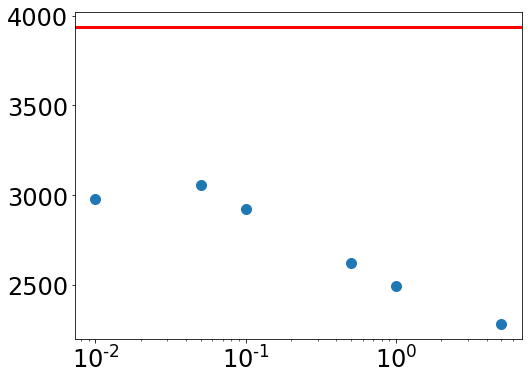

In [12]:
h5_dirs = Path('21-05-11_AMrod_US_binding_scan6.1_uDiff.01-5/simulations/').glob('*/*.h5')
def get_steady_state_stats(arr):
    return arr[int(.75*arr.size):].mean()#, arr[int(.5*arr.size)].std() 


sum_bind_avg = []
calc_vals = []
param_vals = []
length = 1.
for h5_path in h5_dirs:
    time, xlp_bind = get_bind_arr(h5_path)
    
    param_vals += [get_param_val(h5_path, 'diffUnbound')]
    params = get_xl_params(h5_path)
    run_params = get_run_params(h5_path)
    Ka = params['Ka'][0]
    eps = params['eps']
    Nxl = params['freeNumber']
    vol = (run_params['simBoxHigh'][0] - run_params['simBoxLow'][0])**3
    gamma = 2.*Ka*eps*length/vol/602
    calc_vals += [Nxl/(1.+(1./gamma))]
    
    sum_bind_avg += [get_steady_state_stats(np.sum(xlp_bind, axis=0))]

fig, ax = plt.subplots(figsize=(8,6))
_ = ax.scatter(param_vals, sum_bind_avg,)
_ = ax.axhline(calc_vals[0], label = "Fast diffusion limit",color='r')
ax.set_xscale('log')
#ax.set_yscale('log')


### Corrected binding

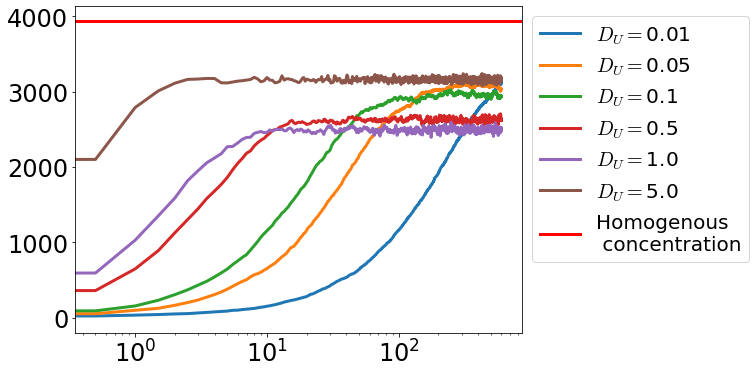

In [13]:
h5_dirs = Path('21-05-12_AMrod_US_binding_scan6.1_uDiff.01-5_correct/simulations/').glob('*/*.h5')

fig, ax = plt.subplots(figsize=(8,6))
label_vals = []
for h5_path in h5_dirs:
    time, xlp_bind = get_bind_arr(h5_path)
    label_vals += [get_param_val(h5_path, 'diffUnbound')]
    params = get_xl_params(h5_path)
    run_params = get_run_params(h5_path)
    _ = ax.plot(time, np.sum(xlp_bind, axis = 0), label=f'$D_U =${label_vals[-1]}')
    Ka = params['Ka'][0]
    eps = params['eps']
    Nxl = params['freeNumber']
    vol = (run_params['simBoxHigh'][0] - run_params['simBoxLow'][0])**3
    gamma = 2.*Ka*eps*length/vol/602
    calc_val = Nxl/(1.+(1./gamma))

    
_ = ax.axhline(calc_val, label = "Homogenous\n concentration",color='r')

_ = ax.legend(bbox_to_anchor=(1,1), loc="upper left")
ax.set_xscale('log')



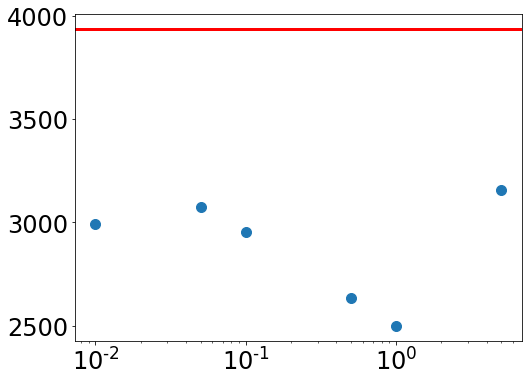

In [14]:
h5_dirs = Path('21-05-12_AMrod_US_binding_scan6.1_uDiff.01-5_correct/simulations/').glob('*/*.h5')
def get_steady_state_stats(arr):
    return arr[int(.75*arr.size):].mean()#, arr[int(.5*arr.size)].std() 


sum_bind_avg = []
calc_vals = []
param_vals = []
length = 1.
for h5_path in h5_dirs:
    time, xlp_bind = get_bind_arr(h5_path)
    
    param_vals += [get_param_val(h5_path, 'diffUnbound')]
    params = get_xl_params(h5_path)
    run_params = get_run_params(h5_path)
    Ka = params['Ka'][0]
    eps = params['eps']
    Nxl = params['freeNumber']
    vol = (run_params['simBoxHigh'][0] - run_params['simBoxLow'][0])**3
    gamma = 2.*Ka*eps*length/vol/602
    calc_vals += [Nxl/(1.+(1./gamma))]
    
    sum_bind_avg += [get_steady_state_stats(np.sum(xlp_bind, axis=0))]

fig, ax = plt.subplots(figsize=(8,6))
_ = ax.scatter(param_vals, sum_bind_avg,)
_ = ax.axhline(calc_vals[0], label = "Fast diffusion limit",color='r')
ax.set_xscale('log')
#ax.set_yscale('log')


## Changing dt

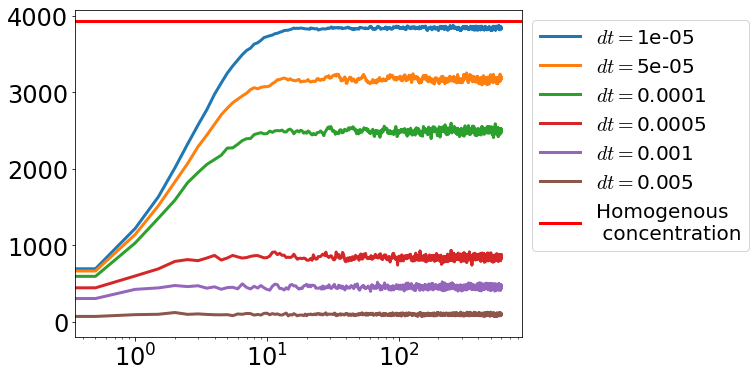

In [15]:
h5_dirs = Path('21-05-12_AMrod_US_binding_scan5.1_uDiff1_dt.000001-.0001/simulations/').glob('*/*.h5')

fig, ax = plt.subplots(figsize=(8,6))
label_vals = []
for h5_path in h5_dirs:
    time, xlp_bind = get_bind_arr(h5_path)
    run_params = get_run_params(h5_path)
    label_vals += [run_params['dt']]
    params = get_xl_params(h5_path)
    
    _ = ax.plot(time, np.sum(xlp_bind, axis = 0), label=f'$dt =${label_vals[-1]}')
    Ka = params['Ka'][0]
    eps = params['eps']
    Nxl = params['freeNumber']
    vol = (run_params['simBoxHigh'][0] - run_params['simBoxLow'][0])**3
    gamma = 2.*Ka*eps*length/vol/602
    calc_val = Nxl/(1.+(1./gamma))

    
ax.axhline(calc_val, label = "Homogenous\n concentration",color='r')

_ = ax.legend(bbox_to_anchor=(1,1), loc="upper left")
ax.set_xscale('log')



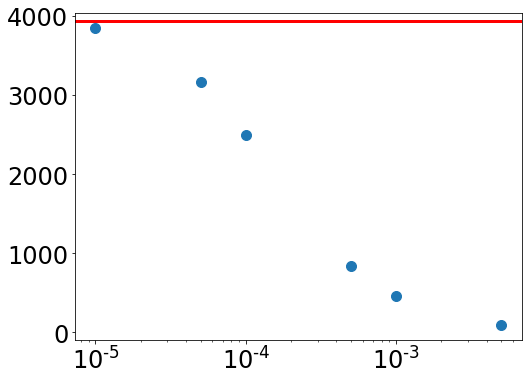

In [16]:
h5_dirs = Path('21-05-12_AMrod_US_binding_scan5.1_uDiff1_dt.000001-.0001/simulations/').glob('*/*.h5')
def get_steady_state_stats(arr):
    return arr[int(.75*arr.size):].mean()#, arr[int(.5*arr.size)].std() 


sum_bind_avg = []
calc_vals = []
param_vals = []
length = 1.
for h5_path in h5_dirs:
    time, xlp_bind = get_bind_arr(h5_path)
    params = get_xl_params(h5_path)
    run_params = get_run_params(h5_path)

    param_vals += [run_params['dt']]    
    Ka = params['Ka'][0]
    eps = params['eps']
    Nxl = params['freeNumber']
    vol = (run_params['simBoxHigh'][0] - run_params['simBoxLow'][0])**3
    gamma = 2.*Ka*eps*length/vol/602
    calc_vals += [Nxl/(1.+(1./gamma))]
    
    sum_bind_avg += [get_steady_state_stats(np.sum(xlp_bind, axis=0))]

fig, ax = plt.subplots(figsize=(8,6))
#ax.scatter(param_vals, Ka_head0_bind_avg, label = "Head 0",)
#ax.scatter(param_vals, Ka_head1_bind_avg, label = "Head 1",)
ax.scatter(param_vals, sum_bind_avg,)
#ax.scatter(param_vals, calc_vals, label = "Calc",)
ax.axhline(calc_vals[0], label = "Fast diffusion limit",color='r')
ax.set_xscale('log')
#ax.set_yscale('log')


### Corrected binding

61.342400332225914
61.342400332225914
61.342400332225914
61.342400332225914
61.342400332225914
61.342400332225914


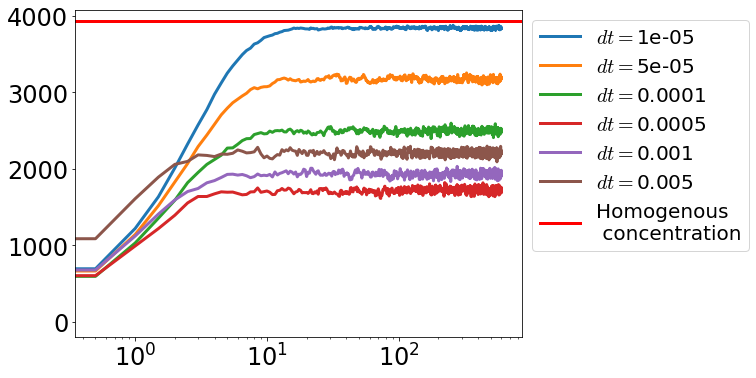

In [17]:
h5_dirs = Path('21-05-14_AMrod_US_binding_scan5.1_uDiff1_dt.000001-.0001_correct/simulations/').glob('*/*.h5')

fig, ax = plt.subplots(figsize=(8,6))
label_vals = []
for h5_path in h5_dirs:
    time, xlp_bind = get_bind_arr(h5_path)
    run_params = get_run_params(h5_path)
    label_vals += [run_params['dt']]
    params = get_xl_params(h5_path)
    
    _ = ax.plot(time, np.sum(xlp_bind, axis = 0), label=f'$dt =${label_vals[-1]}')
    Ka = params['Ka'][0]
    eps = params['eps']
    Nxl = params['freeNumber']
    vol = (run_params['simBoxHigh'][0] - run_params['simBoxLow'][0])**3
    gamma = 2.*Ka*eps*length/vol/602
    print(gamma)
    calc_val = Nxl/(1.+(1./gamma))

    
_ = ax.axhline(calc_val, label = "Homogenous\n concentration",color='r')

_ = ax.legend(bbox_to_anchor=(1,1), loc="upper left")
ax.set_xscale('log')



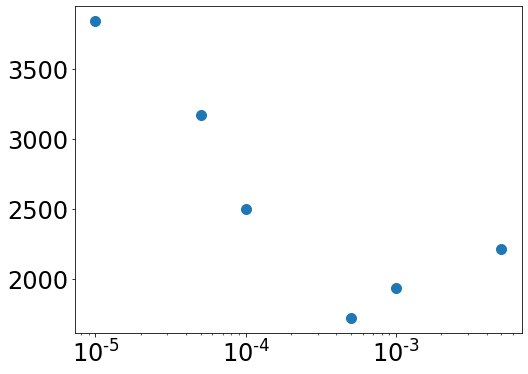

In [18]:
h5_dirs = Path('21-05-14_AMrod_US_binding_scan5.1_uDiff1_dt.000001-.0001_correct/simulations/').glob('*/*.h5')
def get_steady_state_stats(arr):
    return arr[int(.75*arr.size):].mean()#, arr[int(.5*arr.size)].std() 


sum_bind_avg = []
calc_vals = []
param_vals = []
length = 1.
for h5_path in h5_dirs:
    time, xlp_bind = get_bind_arr(h5_path)
    
    
    params = get_xl_params(h5_path)
    run_params = get_run_params(h5_path)
    param_vals += [run_params['dt']]
    Ka = params['Ka'][0]
    eps = params['eps']
    Nxl = params['freeNumber']
    vol = (run_params['simBoxHigh'][0] - run_params['simBoxLow'][0])**3
    gamma = 2.*Ka*eps*length/vol/602
    calc_vals += [Nxl/(1.+(1./gamma))]
    
    sum_bind_avg += [get_steady_state_stats(np.sum(xlp_bind, axis=0))]

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(param_vals, sum_bind_avg,)
#ax.axhline(calc_vals[0], label = "Fast diffusion limit",color='r')
ax.set_xscale('log')


# Reduced binding results $\epsilon = 27 \mu m^{-1}$

In [68]:
# ceph
%cd /mnt/home/alamson/ceph/DATA/AMSOS_Methods/

/mnt/ceph/users/alamson/DATA/AMSOS_Methods


## Diffusion scan

(0.0, 2200.0)

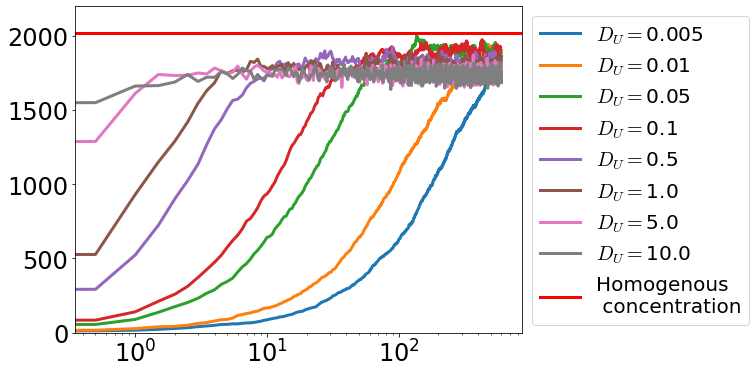

In [69]:
h5_dirs = Path('21-05-18_AMrod_US_binding_scan8.1_eps27_uDiff.005-10/simulations/').glob('*/*.h5')
h5_dirs = sorted(h5_dirs, key=lambda x: get_xl_params(x)['diffUnbound'])

fig, ax = plt.subplots(figsize=(8,6))
label_vals = []
for h5_path in h5_dirs:
    time, xlp_bind = get_bind_arr(h5_path)
    label_vals += [get_param_val(h5_path, 'diffUnbound')]
    params = get_xl_params(h5_path)
    run_params = get_run_params(h5_path)
    _ = ax.plot(time, np.sum(xlp_bind, axis = 0), label=f'$D_U =${label_vals[-1]}')
    Ka = params['Ka'][0]
    eps = params['eps']
    Nxl = params['freeNumber']
    vol = (run_params['simBoxHigh'][0] - run_params['simBoxLow'][0])**3
    gamma = 2.*Ka*eps*length/vol/602
    calc_val = Nxl/(1.+(1./gamma))

    
_ = ax.axhline(calc_val, label = "Homogenous\n concentration",color='r')

_ = ax.legend(bbox_to_anchor=(1,1), loc="upper left")

ax.set_xscale('log')
ax.set_ylim(0,2200)


Text(0.001, 2000, 'A')

(1500.0, 2200.0)

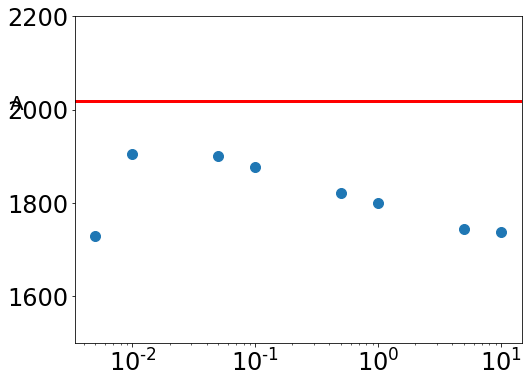

In [71]:
h5_dirs = Path('21-05-18_AMrod_US_binding_scan8.1_eps27_uDiff.005-10/simulations/').glob('*/*.h5')
def get_steady_state_stats(arr):
    return arr[int(.75*arr.size):].mean()


sum_bind_avg = []
calc_vals = []
param_vals = []
length = 1.
for h5_path in h5_dirs:
    time, xlp_bind = get_bind_arr(h5_path)
    
    param_vals += [get_param_val(h5_path, 'diffUnbound')]
    params = get_xl_params(h5_path)
    run_params = get_run_params(h5_path)
    
    Ka = params['Ka'][0]
    eps = params['eps']
    Nxl = params['freeNumber']
    vol = (run_params['simBoxHigh'][0] - run_params['simBoxLow'][0])**3
    gamma = 2.*Ka*eps*length/vol/602
    calc_vals += [Nxl/(1.+(1./gamma))]
    
    sum_bind_avg += [get_steady_state_stats(np.sum(xlp_bind, axis=0))]

fig, ax = plt.subplots(figsize=(8,6))
_ = ax.scatter(param_vals, sum_bind_avg,)
_ = ax.axhline(calc_vals[0], label = "Homogenous\n concentration",color='r')
ax.set_xscale('log')

#ax.set_yscale('log')
ax.set_ylim(1500,2200)

### Corrected binding

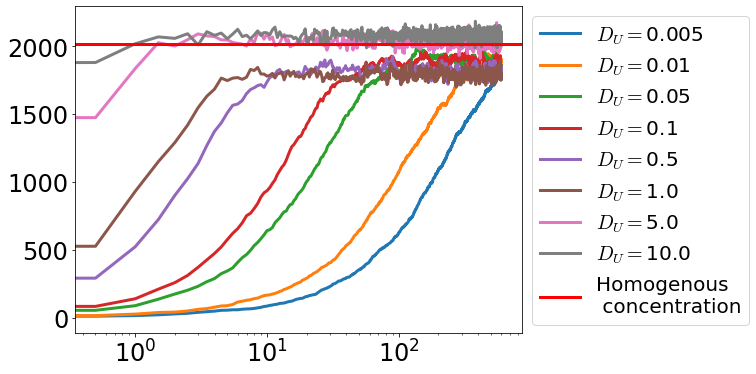

In [22]:
h5_dirs = Path('21-05-18_AMrod_US_binding_scan8.1_eps27_uDiff.005-10_correct/simulations/').glob('*/*.h5')
h5_dirs = sorted(h5_dirs, key=lambda x: get_xl_params(x)['diffUnbound'])

fig, ax = plt.subplots(figsize=(8,6))
label_vals = []
for h5_path in h5_dirs:
    time, xlp_bind = get_bind_arr(h5_path)
    label_vals += [get_param_val(h5_path, 'diffUnbound')]
    params = get_xl_params(h5_path)
    run_params = get_run_params(h5_path)
    _ = ax.plot(time, np.sum(xlp_bind, axis = 0), label=f'$D_U =${label_vals[-1]}')
    Ka = params['Ka'][0]
    eps = params['eps']
    Nxl = params['freeNumber']
    vol = (run_params['simBoxHigh'][0] - run_params['simBoxLow'][0])**3
    gamma = 2.*Ka*eps*length/vol/602
    calc_val = Nxl/(1.+(1./gamma))

    
_ = ax.axhline(calc_val, label = "Homogenous\n concentration",color='r')

_ = ax.legend(bbox_to_anchor=(1,1), loc="upper left")
ax.set_xscale('log')



(1500.0, 2200.0)

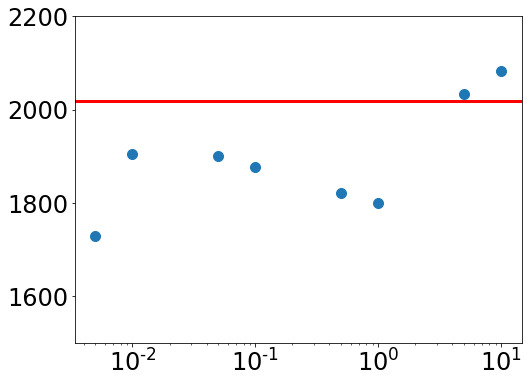

In [23]:
h5_dirs = Path('21-05-18_AMrod_US_binding_scan8.1_eps27_uDiff.005-10_correct/simulations/').glob('*/*.h5')
def get_steady_state_stats(arr):
    return arr[int(.75*arr.size):].mean()

sum_bind_avg = []
calc_vals = []
param_vals = []
length = 1.
for h5_path in h5_dirs:
    time, xlp_bind = get_bind_arr(h5_path)
    param_vals += [get_param_val(h5_path, 'diffUnbound')]
    params = get_xl_params(h5_path)
    run_params = get_run_params(h5_path)

    Ka = params['Ka'][0]
    eps = params['eps']
    Nxl = params['freeNumber']
    vol = (run_params['simBoxHigh'][0] - run_params['simBoxLow'][0])**3
    gamma = 2.*Ka*eps*length/vol/602
    calc_vals += [Nxl/(1.+(1./gamma))]
    
    sum_bind_avg += [get_steady_state_stats(np.sum(xlp_bind, axis=0))]

fig, ax = plt.subplots(figsize=(8,6))
_ = ax.scatter(param_vals, sum_bind_avg,)
_ = ax.axhline(calc_vals[0], label = "Homogenous concentration",color='r')

ax.set_xscale('log')
ax.set_ylim(1500,2200)
#ax.set_yscale('log')


## Changing dt

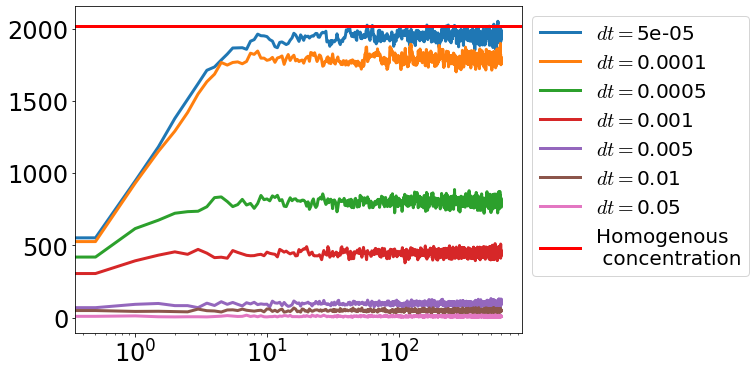

In [24]:
h5_dirs = list(Path('21-05-18_AMrod_US_binding_scan8.1_eps27_uDiff1_dt.1e-5-.05/simulations/').glob('*/*.h5'))
h5_dirs = sorted(h5_dirs, key=lambda x: get_run_params(x)['dt'])

fig, ax = plt.subplots(figsize=(8,6))
label_vals = []
for h5_path in h5_dirs:
    time, xlp_bind = get_bind_arr(h5_path)
    run_params = get_run_params(h5_path)
    label_vals += [run_params['dt']]
    params = get_xl_params(h5_path)
    
    _ = ax.plot(time, np.sum(xlp_bind, axis = 0), label=f'$dt =${label_vals[-1]}')
    Ka = params['Ka'][0]
    eps = params['eps']
    Nxl = params['freeNumber']
    vol = (run_params['simBoxHigh'][0] - run_params['simBoxLow'][0])**3
    gamma = 2.*Ka*eps*length/vol/602
    calc_val = Nxl/(1.+(1./gamma))

    
ax.axhline(calc_val, label = "Homogenous\n concentration",color='r')

_ = ax.legend(bbox_to_anchor=(1,1), loc="upper left")
ax.set_xscale('log')



(0.0, 2200.0)

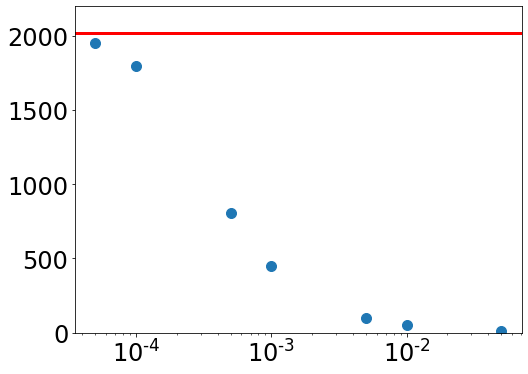

In [25]:
h5_dirs = Path('21-05-18_AMrod_US_binding_scan8.1_eps27_uDiff1_dt.1e-5-.05/simulations/').glob('*/*.h5')
def get_steady_state_stats(arr):
    return arr[int(.75*arr.size):].mean()#, arr[int(.5*arr.size)].std() 


sum_bind_avg = []
calc_vals = []
param_vals = []
length = 1.
for h5_path in h5_dirs:
    time, xlp_bind = get_bind_arr(h5_path)
    params = get_xl_params(h5_path)
    run_params = get_run_params(h5_path)

    param_vals += [run_params['dt']]    
    Ka = params['Ka'][0]
    eps = params['eps']
    Nxl = params['freeNumber']
    vol = (run_params['simBoxHigh'][0] - run_params['simBoxLow'][0])**3
    gamma = 2.*Ka*eps*length/vol/602
    calc_vals += [Nxl/(1.+(1./gamma))]
    
    #Ka_head0_bind_avg += [get_steady_state_stats(xlp_bind[0,:])]
    #Ka_head1_bind_avg += [get_steady_state_stats(xlp_bind[1,:])]
    sum_bind_avg += [get_steady_state_stats(np.sum(xlp_bind, axis=0))]

fig, ax = plt.subplots(figsize=(8,6))
#ax.scatter(param_vals, Ka_head0_bind_avg, label = "Head 0",)
#ax.scatter(param_vals, Ka_head1_bind_avg, label = "Head 1",)
ax.scatter(param_vals, sum_bind_avg,)
#ax.scatter(param_vals, calc_vals, label = "Calc",)
ax.axhline(calc_vals[0], label = "Homogenous concentration",color='r')
ax.set_xscale('log')
ax.set_ylim(0,2200)
#ax.set_yscale('log')


### Corrected binding

1.0192275747508306
1.0192275747508306
1.0192275747508306
1.0192275747508306
1.0192275747508306
1.0192275747508306
1.0192275747508306


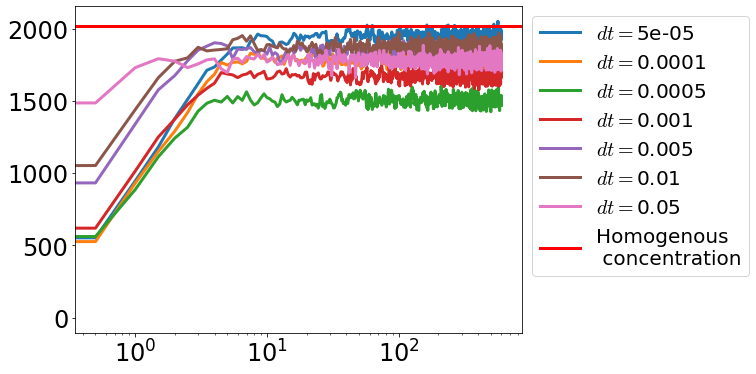

In [26]:
h5_dirs = list(Path('21-05-18_AMrod_US_binding_scan8.1_eps27_uDiff1_dt.1e-5-.05_correct/simulations/').glob('*/*.h5'))
h5_dirs = sorted(h5_dirs, key=lambda x: get_run_params(x)['dt'])

fig, ax = plt.subplots(figsize=(8,6))
label_vals = []
for h5_path in h5_dirs:
    time, xlp_bind = get_bind_arr(h5_path)
    run_params = get_run_params(h5_path)
    label_vals += [run_params['dt']]
    params = get_xl_params(h5_path)
    
    _ = ax.plot(time, np.sum(xlp_bind, axis = 0), label=f'$dt =${label_vals[-1]}')
    Ka = params['Ka'][0]
    eps = params['eps']
    Nxl = params['freeNumber']
    vol = (run_params['simBoxHigh'][0] - run_params['simBoxLow'][0])**3
    gamma = 2.*Ka*eps*length/vol/602
    print(gamma)
    calc_val = Nxl/(1.+(1./gamma))

    
_ = ax.axhline(calc_val, label = "Homogenous\n concentration", color='r')

_ = ax.legend(bbox_to_anchor=(1,1), loc="upper left")
ax.set_xscale('log')



(0.0, 2200.0)

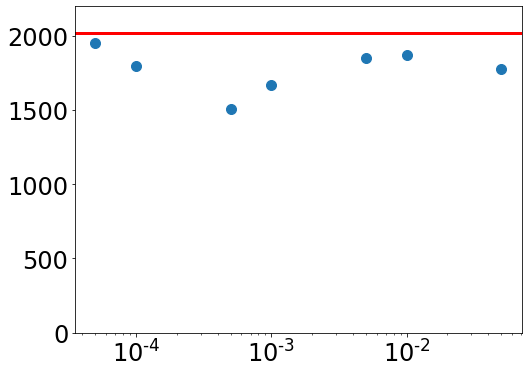

In [27]:
h5_dirs = Path('21-05-18_AMrod_US_binding_scan8.1_eps27_uDiff1_dt.1e-5-.05_correct/simulations/').glob('*/*.h5')
def get_steady_state_stats(arr):
    return arr[int(.75*arr.size):].mean()#, arr[int(.5*arr.size)].std() 


sum_bind_avg = []
calc_vals = []
param_vals = []
length = 1.
for h5_path in h5_dirs:
    time, xlp_bind = get_bind_arr(h5_path)
    params = get_xl_params(h5_path)
    run_params = get_run_params(h5_path)

    param_vals += [run_params['dt']]    
    Ka = params['Ka'][0]
    eps = params['eps']
    Nxl = params['freeNumber']
    vol = (run_params['simBoxHigh'][0] - run_params['simBoxLow'][0])**3
    gamma = 2.*Ka*eps*length/vol/602
    calc_vals += [Nxl/(1.+(1./gamma))]
    
    #Ka_head0_bind_avg += [get_steady_state_stats(xlp_bind[0,:])]
    #Ka_head1_bind_avg += [get_steady_state_stats(xlp_bind[1,:])]
    sum_bind_avg += [get_steady_state_stats(np.sum(xlp_bind, axis=0))]

fig, ax = plt.subplots(figsize=(8,6))
#ax.scatter(param_vals, Ka_head0_bind_avg, label = "Head 0",)
#ax.scatter(param_vals, Ka_head1_bind_avg, label = "Head 1",)
ax.scatter(param_vals, sum_bind_avg,)
#ax.scatter(param_vals, calc_vals, label = "Calc",)
ax.axhline(calc_vals[0], label = "Homogeneous concentration",color='r')
ax.set_xscale('log')
ax.set_ylim(0,2200)
#ax.set_yscale('log')


# Conclusions and Next Steps

In [28]:
%cd /mnt/home/alamson/ceph/DATA/AMSOS_Methods/

/mnt/ceph/users/alamson/DATA/AMSOS_Methods


In [102]:

def param_vs_time_graphs(ax, h5_paths, get_dict_func, param, label_str, length=1.):
    label_vals = []
    for h5_path in h5_paths:
        #print(h5_path)
        try:
            time, xlp_bind = get_bind_arr(h5_path)
            label_vals += [get_dict_func(h5_path)[param]]
            params = get_xl_params(h5_path)
            run_params = get_run_params(h5_path)
            #_ = ax.plot(time, np.sum(xlp_bind, axis = 0), label=f'$D_U =${label_vals[-1]}')
            _ = ax.plot(time, np.sum(xlp_bind, axis = 0), label=label_str.format(label_vals[-1]))
            Ka = params['Ka'][0]
            eps = params['eps']
            Nxl = params['freeNumber']
            vol = (run_params['simBoxHigh'][0] - run_params['simBoxLow'][0])**3
            gamma = 2.*Ka*eps*length/vol/602
            calc_val = Nxl/(1.+(1./gamma))
        except:
            continue


    _ = ax.axhline(calc_val, label = "Homogenous\nconcentration",color='r')

    ax.set_xscale('log')
    ax.set_ylim(0,2200)

In [103]:
def get_steady_state_stats(arr, frac_run=.75):
    return arr[int(frac_run*arr.size):].mean(), arr[int(frac_run*arr.size):].std()

def get_nbound_calc(xl_params, run_params):
    Ka = xl_params['Ka'][0]
    eps = xl_params['eps']
    Nxl = xl_params['freeNumber']
    vol = (run_params['simBoxHigh'][0] - run_params['simBoxLow'][0])**3
    gamma = 2.*Ka*eps*length/vol/602
    return Nxl/(1.+(1./gamma))

def bound_vs_param_compare(ax, h5_paths, h5_c_paths, get_dict_func, param):
    sum_bind_avg = []
    sum_bind_c_avg = []
    sum_bind_std = []
    sum_bind_c_std = []
    
    
    calc_vals = []
    param_vals = []
    length = 1.
    for h5_path, h5_c_path in zip(h5_paths, h5_c_paths):
        try:
            time, xlp_bind = get_bind_arr(h5_path)
            time, xlp_c_bind = get_bind_arr(h5_c_path)

            param_vals += [get_dict_func(h5_path)[param]]
            
            xl_params = get_xl_params(h5_path)
            run_params = get_run_params(h5_path)    

            calc_vals += [get_nbound_calc(xl_params, run_params)]

            avg, std = get_steady_state_stats(np.sum(xlp_bind, axis=0))
            c_avg, c_std = get_steady_state_stats(np.sum(xlp_c_bind, axis=0))

            sum_bind_avg += [avg]
            sum_bind_c_avg += [c_avg]
            sum_bind_std += [std]
            sum_bind_c_std += [c_std]
        except:
            continue

    ax.errorbar(param_vals, sum_bind_avg, yerr=sum_bind_std, fmt="kx", label='$r_{c,S} = (\ell_o + D_{fil})/2$')
    ax.errorbar(param_vals, sum_bind_c_avg, yerr=sum_bind_c_std,  fmt="ko", label='$r_{c,S}= \sqrt{6d_U \Delta t}$')
    ax.axhline(calc_vals[0], color='r')
    ax.set_xscale('log')
    ax.set_ylim(0,2200)
    

## $d_U$ and $dt$ combined graph 

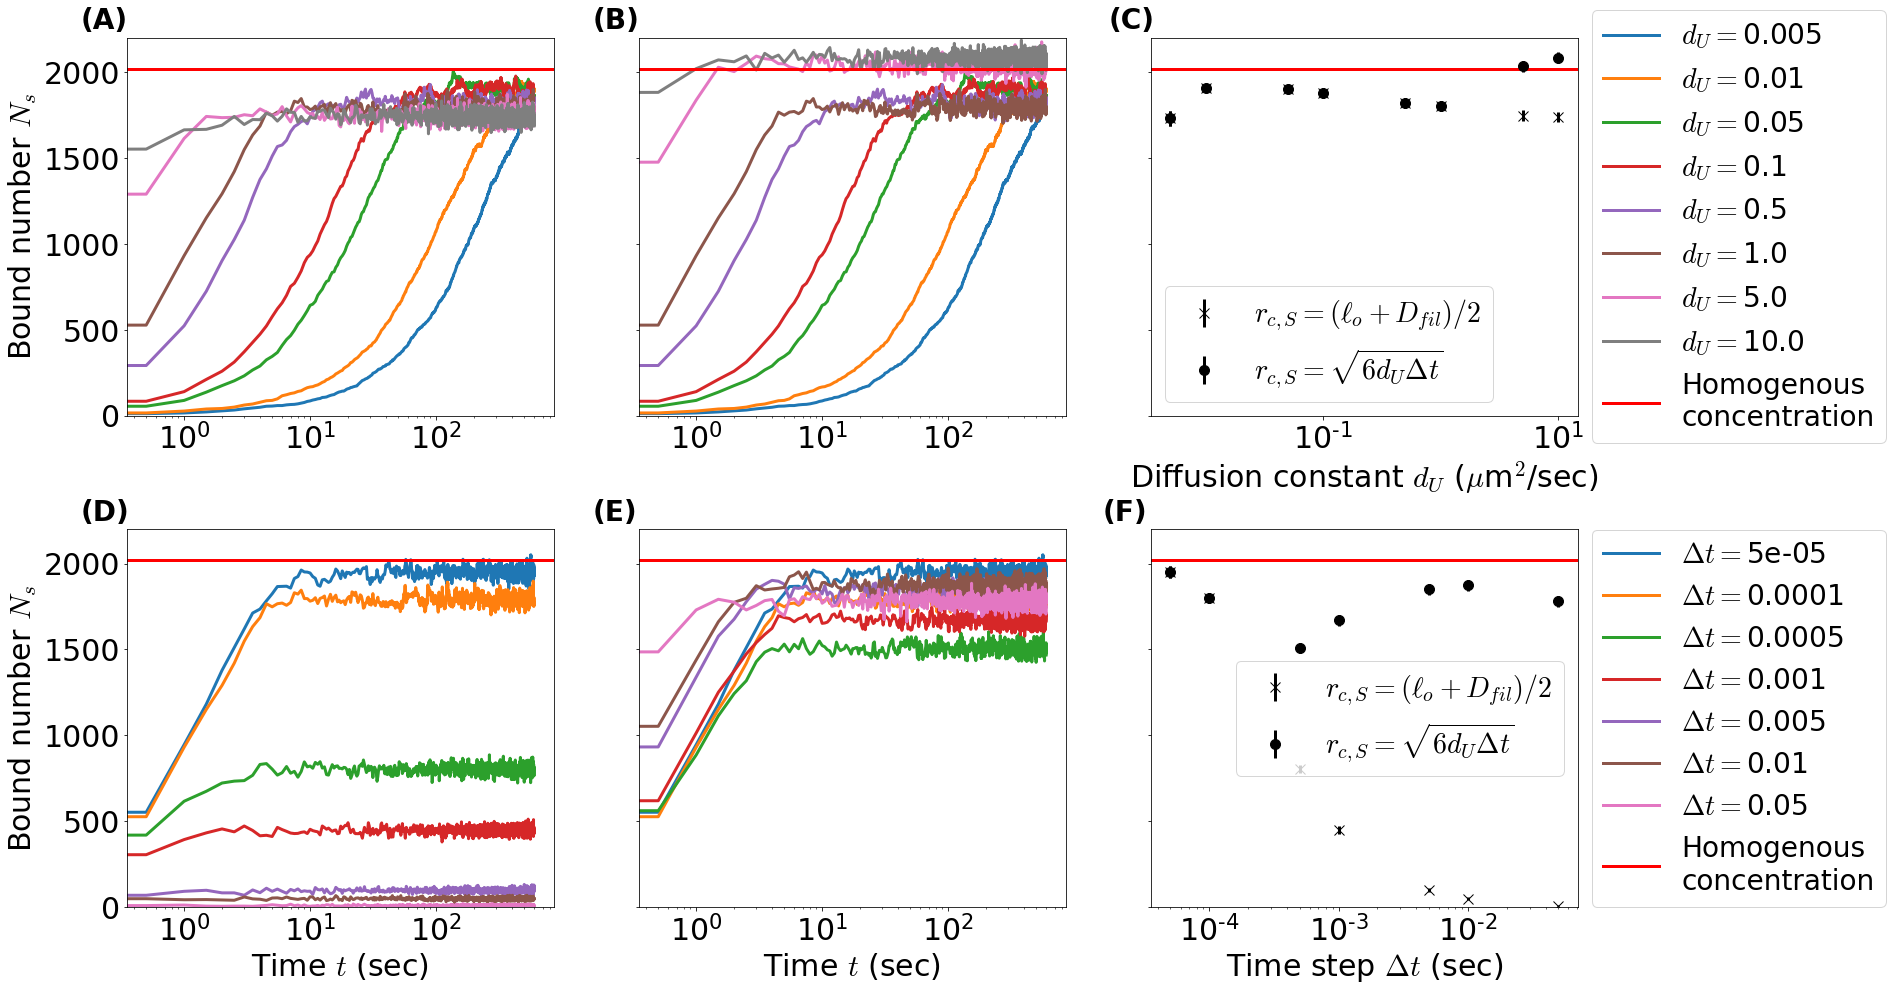

In [112]:
fig, axarr = plt.subplots(2,3, figsize=(26,16), sharey='all')

h5_ud_dirs = sorted(Path('21-05-18_AMrod_US_binding_scan8.1_eps27_uDiff.005-10/simulations/').glob('*/*.h5'), key=lambda x: get_xl_params(x)['diffUnbound'])
h5_ud_c_dirs = sorted(Path('21-05-18_AMrod_US_binding_scan8.1_eps27_uDiff.005-10_correct/simulations/').glob('*/*.h5'), key=lambda x: get_xl_params(x)['diffUnbound'])
h5_dt_dirs = sorted(Path('21-05-18_AMrod_US_binding_scan8.1_eps27_uDiff1_dt.1e-5-.05/simulations/').glob('*/*.h5'), key=lambda x: get_run_params(x)['dt'])
h5_dt_c_dirs = sorted(Path('21-05-18_AMrod_US_binding_scan8.1_eps27_uDiff1_dt.1e-5-.05_correct/simulations/').glob('*/*.h5'), key=lambda x: get_run_params(x)['dt'])


param_vs_time_graphs(axarr[0,0], h5_ud_dirs, get_xl_params, 'diffUnbound', '$d_U =${}')
param_vs_time_graphs(axarr[0,1], h5_ud_c_dirs, get_xl_params, 'diffUnbound', '$d_U =${}')
param_vs_time_graphs(axarr[1,0], h5_dt_dirs, get_run_params, 'dt', '$\Delta t =${}')
param_vs_time_graphs(axarr[1,1], h5_dt_c_dirs, get_run_params, 'dt', '$\Delta t =${}')

bound_vs_param_compare(axarr[0,2], h5_ud_dirs, h5_ud_c_dirs, get_xl_params, 'diffUnbound',)
bound_vs_param_compare(axarr[1,2], h5_dt_dirs, h5_dt_c_dirs, get_run_params, 'dt',)
    
#_ = ax.axhline(calc_val, label = "Homogenous\n concentration",color='r')


_ = axarr[0,0].set_ylabel('Bound number $N_s$')
_ = axarr[1,0].set_ylabel('Bound number $N_s$')


_ = axarr[1,0].set_xlabel('Time $t$ (sec)')
_ = axarr[1,1].set_xlabel('Time $t$ (sec)')

_ = axarr[0,2].set_xlabel('Diffusion constant $d_{U}$ ($\mu$m$^2$/sec)')
_ = axarr[1,2].set_xlabel('Time step $\Delta t$ (sec)')

_ = axarr[0,1].legend(bbox_to_anchor=(2.2,0.5), loc="center left")
_ = axarr[1,1].legend(bbox_to_anchor=(2.2,0.5), loc="center left")
_ = axarr[0,2].legend()
_ = axarr[1,2].legend()

x_fig_mark = .15
y_fig_mark = 2250

title_font = {'family': 'sanserif',
        'weight': 'bold',
        'size': 28
        }

_ = axarr[0,0].text(x_fig_mark, y_fig_mark, "(A)", font=title_font)
_ = axarr[0,1].text(x_fig_mark, y_fig_mark, "(B)", font=title_font)
_ = axarr[0,2].text(.0015, y_fig_mark, "(C)", font=title_font)

_ = axarr[1,0].text(x_fig_mark, y_fig_mark, "(D)", font=title_font)
_ = axarr[1,1].text(x_fig_mark, y_fig_mark, "(E)", font=title_font)
_ = axarr[1,2].text(.000015, y_fig_mark, "(F)", font=title_font)

fig.subplots_adjust(hspace=.3)

#fig.tight_layout()

## $r_c$ graph with half length and 2x binding site

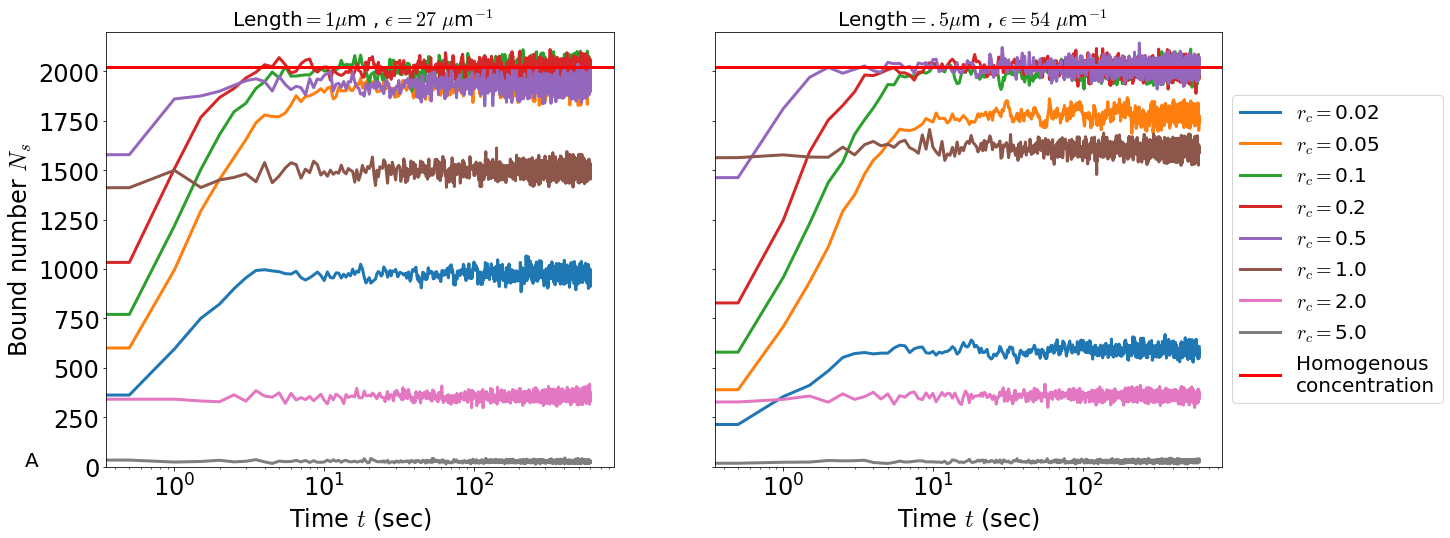

In [105]:
fig, axarr = plt.subplots(1,2, figsize=(20,8), sharey='all')

h5_rc_eps27_dirs = sorted((ceph_path / '21-07-01_AMrod_US_binding_scan8.1_eps27_rcs.02-5/simulations').glob('*/*.h5'), key=lambda x: get_xl_params(x)['rc'])
h5_rc_eps54_dirs = sorted((ceph_path / '21-07-01_AMrod_US_binding_scan8.1_eps54_L.5_rc.02-5/simulations').glob('*/*.h5'), key=lambda x: get_xl_params(x)['rc'])

param_vs_time_graphs(axarr[0], h5_rc_eps27_dirs, get_xl_params, 'rc', '$r_c =${}')
param_vs_time_graphs(axarr[1], h5_rc_eps54_dirs, get_xl_params, 'rc', '$r_c =${}', length=.5)

_ = axarr[0].set_title(' Length$= 1 \mu$m , $\epsilon= 27$ $\mu$m$^{-1}$')
_ = axarr[0].text(.1, 1, "A")
_ = axarr[1].set_title(' Length$= .5 \mu$m , $\epsilon= 54$ $\mu$m$^{-1}$')

_ = axarr[0].set_ylabel('Bound number $N_s$')

_ = axarr[0].set_xlabel('Time $t$ (sec)')
_ = axarr[1].set_xlabel('Time $t$ (sec)')

_ = axarr[1].legend(bbox_to_anchor=(1.0,0.5), loc="center left")

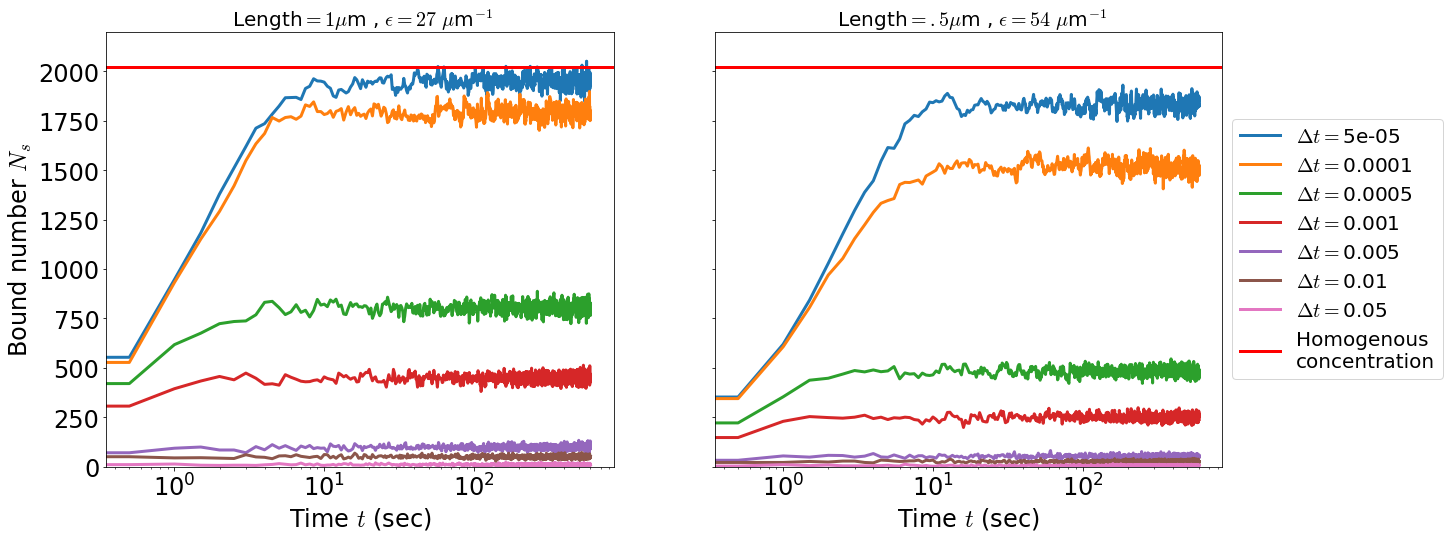

In [106]:
fig, axarr = plt.subplots(1,2, figsize=(20,8), sharey='all')

h5_dt_eps27_dirs = sorted((ceph_path / '21-05-18_AMrod_US_binding_scan8.1_eps27_uDiff1_dt.1e-5-.05/simulations/').glob('*/*.h5'), key=lambda x: get_run_params(x)['dt'])
h5_dt_eps54_dirs = sorted((mnt_path / '21-07-01_AMrod_US_binding_scan8.1_eps54_L.5_dt.1e-5-.05/simulations').glob('*/*.h5'), key=lambda x: get_run_params(x)['dt'])

param_vs_time_graphs(axarr[0], h5_dt_eps27_dirs, get_run_params, 'dt', '$\Delta t =${}')
param_vs_time_graphs(axarr[1], h5_dt_eps54_dirs, get_run_params, 'dt', '$\Delta t =${}', length=.5)

_ = axarr[0].set_title(' Length$= 1 \mu$m , $\epsilon= 27$ $\mu$m$^{-1}$')
_ = axarr[1].set_title(' Length$= .5 \mu$m , $\epsilon= 54$ $\mu$m$^{-1}$')

_ = axarr[0].set_ylabel('Bound number $N_s$')

_ = axarr[0].set_xlabel('Time $t$ (sec)')
_ = axarr[1].set_xlabel('Time $t$ (sec)')

_ = axarr[1].legend(bbox_to_anchor=(1.0,0.5), loc="center left")

# Compare with increased binding radius

UnboundLocalError: local variable 'calc_val' referenced before assignment

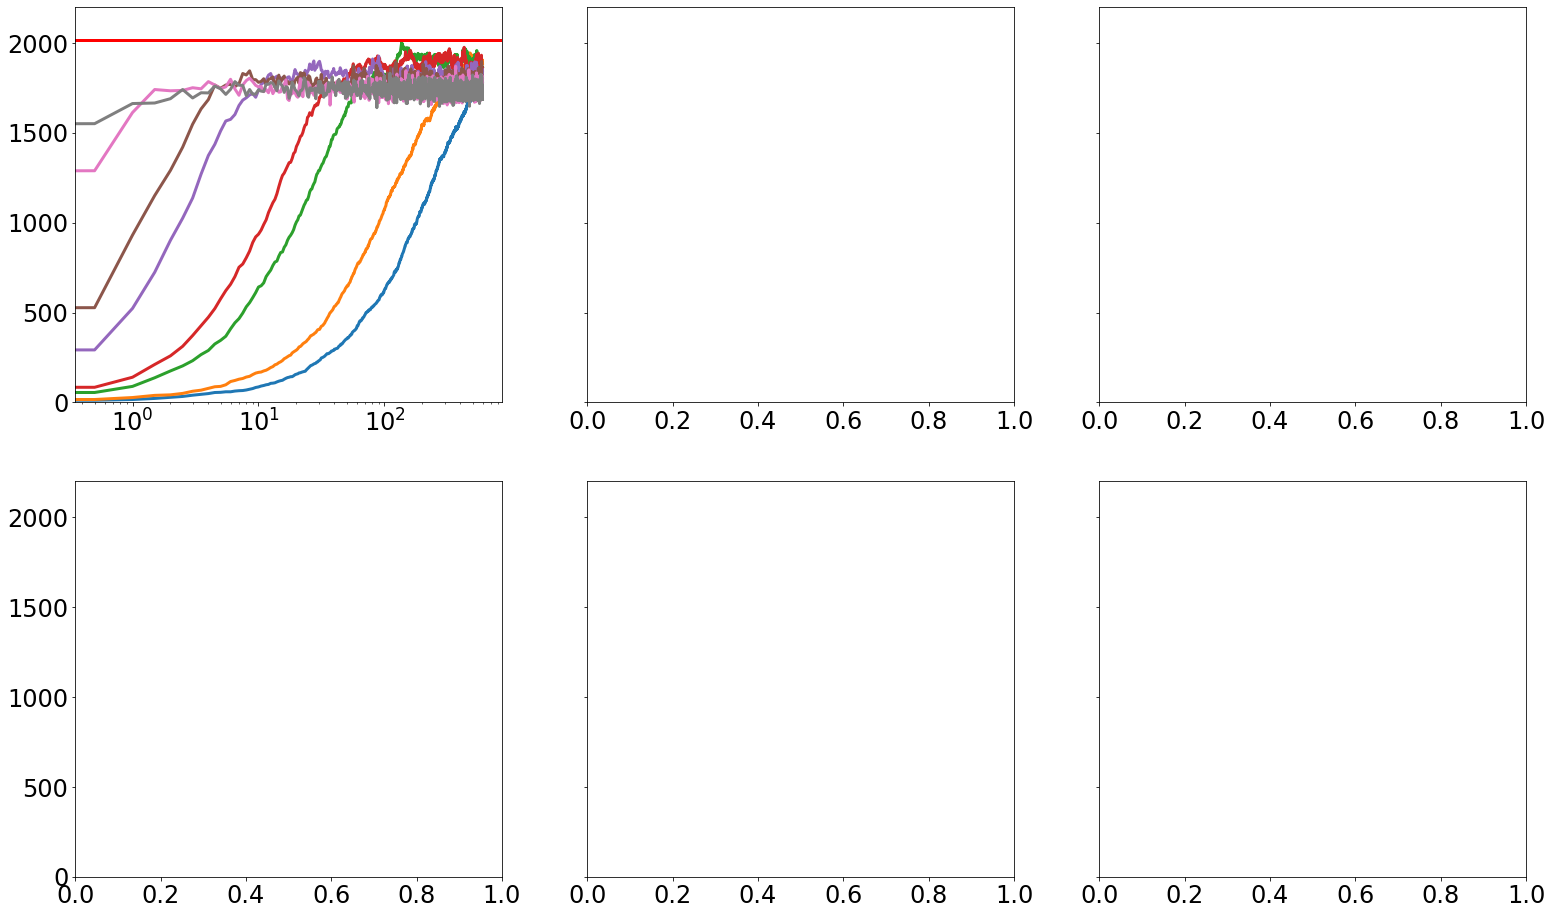

In [32]:
fig, axarr = plt.subplots(2,3, figsize=(26,16), sharey='all')

h5_ud_dirs = sorted(Path('21-05-18_AMrod_US_binding_scan8.1_eps27_uDiff.005-10/simulations/').glob('*/*.h5'), key=lambda x: get_xl_params(x)['diffUnbound'])
h5_ud_c_dirs = sorted((mnt_path / '21-06-16_AMrod_US_binding_scan8.1_eps27_uDiff.005-10_sqrt2/simulations/').glob('*/*.h5'), key=lambda x: get_xl_params(x)['diffUnbound'])
h5_dt_dirs = sorted(Path('21-05-18_AMrod_US_binding_scan8.1_eps27_uDiff1_dt.1e-5-.05/simulations/').glob('*/*.h5'), key=lambda x: get_run_params(x)['dt'])
h5_dt_c_dirs = sorted((mnt_path / '21-06-16_US_binding_scan8.1_eps27_uDiff1_dt.1e-5-.05_sqrt2/simulations/').glob('*/*.h5'), key=lambda x: get_run_params(x)['dt'])


param_vs_time_graphs(axarr[0,0], h5_ud_dirs, get_xl_params, 'diffUnbound', '$D_U =${}')
param_vs_time_graphs(axarr[0,1], h5_ud_c_dirs, get_xl_params, 'diffUnbound', '$D_U =${}')
param_vs_time_graphs(axarr[1,0], h5_dt_dirs, get_run_params, 'dt', '$dt =${}')
param_vs_time_graphs(axarr[1,1], h5_dt_c_dirs, get_run_params, 'dt', '$dt =${}')

bound_vs_param_compare(axarr[0,2], h5_ud_dirs, h5_ud_c_dirs, get_xl_params, 'diffUnbound',)
bound_vs_param_compare(axarr[1,2], h5_dt_dirs, h5_dt_c_dirs, get_run_params, 'dt',)
    
#_ = ax.axhline(calc_val, label = "Homogenous\n concentration",color='r')

_ = axarr[0,0].set_ylabel('Bound number $N_s$')
_ = axarr[1,0].set_ylabel('Bound number $N_s$')

_ = axarr[1,0].set_xlabel('Time $t$ (sec)')
_ = axarr[1,1].set_xlabel('Time $t$ (sec)')

_ = axarr[0,2].set_xlabel('Diffusion constant $D_{U}$ ($\mu$m$^2$/sec)')
_ = axarr[1,2].set_xlabel('Time step $dt$ (sec)')

_ = axarr[0,1].legend(bbox_to_anchor=(2.2,0.5), loc="center left")
_ = axarr[1,1].legend(bbox_to_anchor=(2.2,0.5), loc="center left")
_ = axarr[0,2].legend()
_ = axarr[1,2].legend()

fig.subplots_adjust(hspace=.3)

#fig.tight_layout()

Something went wrong...